In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.stats import skew
import seaborn as sns
import sklearn
import warnings
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.externals import joblib


In [76]:
#MSSubClass is set of discrete ints, so this makes it easier to use it as a categorical feature
train_clean = pd.read_csv('train_clean.csv', dtype={'MSSubClass': str})  
train = pd.read_csv('train.csv', dtype={'MSSubClass': str})

In [78]:
kf = KFold(4)

Let's calculate the errors a lasso makes when predicting the training set to see if we can learn anything from them. 

In [79]:
val_idx_list = []
val_preds = []
train_preds = []
val_errors = []
X_train = train_clean.drop('SalePrice', axis=1)
y_train = train_clean['SalePrice']

for tr_idx, val_idx in kf.split(train):
    X_tr, y_tr = X_train.iloc[tr_idx, :], y_train.iloc[tr_idx]
    X_val, y_val = X_train.iloc[val_idx, :], y_train.iloc[val_idx]
    val_idx_list.append(val_idx)
    ls = Lasso(alpha=0.001) #the hyperparameter we found to be best
    ls.fit(X_tr, y_tr)
    preds = ls.predict(X_val)
    val_preds.append(preds)
    val_errors.append(np.abs(y_val.values - preds))
    tr_preds = ls.predict(X_tr) 
    train_preds.append(tr_preds)

In [80]:
val_idx = np.concatenate([l for l in val_idx_list])
val_preds = np.concatenate([p for p in val_preds])
val_errors = np.concatenate([e for e in val_errors])
merge_df = pd.DataFrame(np.hstack([val_preds[:, np.newaxis], val_errors[:, np.newaxis]]), columns=['log_pred', 'log_error'], index=val_idx)
err_df = train.merge(merge_df, left_index=True, right_index=True)

In [81]:
err_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_pred,log_error
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500,12.249437,0.001738
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2007,WD,Normal,181500,12.177764,0.068748
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,223500,12.298457,0.018714
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,12.101622,0.252217
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,12,2008,WD,Normal,250000,12.641516,0.212296


In [82]:
err_df['pred'] = np.expm1(err_df.log_pred)
err_df['abs_error'] = np.abs(err_df.SalePrice - err_df.pred)
err_df['error'] = -(err_df.SalePrice - err_df.pred)

In [83]:
err_df.error.describe()

count      1460.000000
mean      -1593.967536
std       30087.792098
min     -235906.429745
25%      -10056.719942
50%        -915.391905
75%        8717.175741
max      611095.318693
Name: error, dtype: float64

Let's plot the errors versus saleprice and our predictions to get a better sense of where we went wrong.

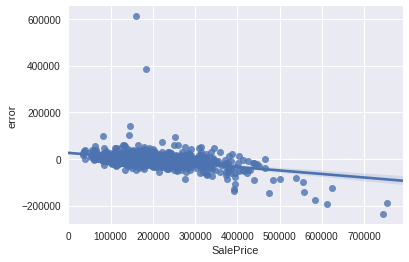

In [84]:
sns.regplot(x='SalePrice', y='error', data=err_df)

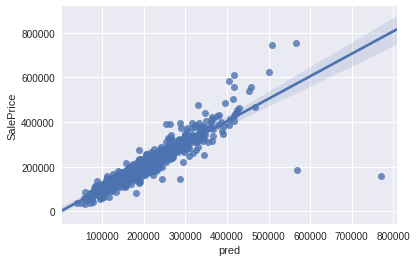

In [85]:
sns.regplot(y='SalePrice', x='pred', data=err_df)

It looks like we have four houses where we were way off. Let's take a look at them.

In [86]:
most_wrong = err_df.sort_values('abs_error', ascending=False)[:4]

In [87]:
most_wrong.index.values

array([1298,  523, 1182,  898])

In [88]:
most_wrong.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_pred,log_error,pred,abs_error,error
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,1,2008,New,Partial,160000,13.555569,1.572633,771095.318693,611095.318693,611095.318693
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,10,2007,New,Partial,184750,13.251875,1.125111,569135.243463,384385.243463,384385.243463
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,7,2007,WD,Abnorml,745000,13.140389,0.380752,509093.570255,235906.429745,-235906.429745
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,3,2010,New,Partial,611657,12.940799,0.383130,416981.160972,194675.839028,-194675.839028


From a previous notebook, we learned that GrLivingArea, Neighborhood and OverallQual were the most important features. So let's hone in on those. 

In [89]:
train.GrLivArea.mean()

1515.463698630137

In [90]:
most_wrong.GrLivArea.mean()

4289.5

In [91]:
most_wrong.Neighborhood

1298    Edwards
523     Edwards
1182    NoRidge
898     NridgHt
Name: Neighborhood, dtype: object

In [92]:
train.OverallQual.mean()

6.0993150684931505

In [93]:
most_wrong.OverallQual.mean()

9.75

We can see that our potential outliers are large, high-quality houses. What's interesting is that we predicted too low a price for two of them, and too high a price for the other two. 

Two of the houses are partial sales and one was abnormal. Maybe that has something to do with it?

Neighborhood could also be the culprit. When we fit our original model, we found the Edwards neighborhood to be one of the strongest negative predictors of price. The two houses where we predicted too high a price were in Edwards. Maybe that's what dragged their price down?

Let's remove the outliers, fit a new model, and see what happens.

In [94]:
most_wrong.index.values

array([1298,  523, 1182,  898])

In [108]:
no_outliers = train_clean.drop(train_clean.index[most_wrong.index.values])

In [109]:
X = no_outliers.drop(['SalePrice','Id'], axis=1)
y = no_outliers['SalePrice']

In [110]:
ls = Lasso(alpha=0.001)

In [111]:
ls.fit(X,y)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [112]:
test = pd.read_csv('test_clean.csv')
X_test = test.drop('Id', axis=1)

In [113]:
preds = ls.predict(X_test)

In [114]:
preds = np.expm1(preds)

solution = pd.DataFrame({"id":test.Id, "SalePrice":preds}, columns=['id', 'SalePrice'])

solution.to_csv("lasso_no_outliers.csv", index = False)

That submission did score better that our previous submission. But I later discovered that removing only two of those four houses (the ones for which we predicted too high a price) worked even better. I think this is because many of our larger errors tended to be where we predicted too low a price. Removing the outliers where the price was unexpectedly low may have corrected some of this.